In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [72]:
import gc

# After you have created your final processed sets:
# Delete the massive raw dataframes
del train_df
del train_transaction
del train_identity

# Force Python to actually free the RAM
gc.collect()

36462

In [73]:
# --- 1. Load and Merge Data ---

# Load data
train_transaction = pd.read_csv('C:/Users/Matúš/Desktop/Marekova praca/Prediction-of-Fraud-transactions/input/train_transaction.csv')
train_identity = pd.read_csv('C:/Users/Matúš/Desktop/Marekova praca/Prediction-of-Fraud-transactions/input/train_identity.csv')
# train_transaction = pd.read_csv('C:/Users/Marek/Desktop/2024-2025/Diplomová práca/Diplomová práca/Prediction-of-Fraud-transactions/input/train_transaction.csv')
# train_identity = pd.read_csv('C:/Users/Marek/Desktop/2024-2025/Diplomová práca/Diplomová práca/Prediction-of-Fraud-transactions/input/train_identity.csv')

# Merge datasets
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

# Simple target definition
# X_check = train_df.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
# y_check = train_df['isFraud']

In [74]:
# 1. Create a UID to track "users" across time
train_df['uid'] = train_df['card1'].astype(str)+'_'+train_df['card2'].astype(str)+'_'+train_df['addr1'].astype(str)

# 2. Transaction Amount relative to User Average
# Does this user usually spend $10 but is now spending $1000?
train_df['uid_Amt_mean'] = train_df.groupby(['uid'])['TransactionAmt'].transform('mean')
train_df['uid_Amt_std'] = train_df.groupby(['uid'])['TransactionAmt'].transform('std')
train_df['Amt_to_mean_ratio'] = train_df['TransactionAmt'] / train_df['uid_Amt_mean']

# 3. Time Engineering
# Fraud often peaks at 3 AM or on weekends.
train_df['hour'] = (train_df['TransactionDT'] // 3600) % 24
train_df['day_of_week'] = (train_df['TransactionDT'] // (3600 * 24)) % 7

# 2. Calculate Cutoff Points
n_total = len(train_df)
idx_train_end = int(n_total * 0.70)      # End of first 70%
idx_val_end   = int(n_total * 0.85)      # End of next 15% (70+15=85)

In [85]:
# 3. Slice the Dataframe
# .iloc works by position [start : end]
train_set = train_df.iloc[ :idx_train_end]              # 0% to 70%
val_set   = train_df.iloc[idx_train_end : idx_val_end]  # 70% to 85%
test_set  = train_df.iloc[idx_val_end: ]                # 85% to 100%

In [86]:
cols_to_drop = ['isFraud', 'TransactionID', 'TransactionDT']

# TRAIN
X_train = train_set.drop(cols_to_drop, axis=1)
y_train = train_set['isFraud']

# VALIDATION
X_val = val_set.drop(cols_to_drop, axis=1)
y_val = val_set['isFraud']

# TEST (The Hold-out)
X_test = test_set.drop(cols_to_drop, axis=1)
y_test = test_set['isFraud']

In [77]:
missing_threshold = 0.80

missing_series = X_train.isnull().mean()
drop_cols = missing_series[missing_series > missing_threshold].index
print(f"Dropping {len(drop_cols)} columns with > {missing_threshold:.0%} missing values.")

X_train_clean = X_train.drop(columns=drop_cols)
X_val_clean   = X_val.drop(columns=drop_cols)
X_test_clean  = X_test.drop(columns=drop_cols)

Dropping 74 columns with > 80% missing values.


In [78]:
X_xgb = X_train_clean.copy()

print("Encoding categorical columns for XGBoost...")
for col in X_xgb.select_dtypes(include=['object']).columns:
    X_xgb[col] = X_xgb[col].astype('category').cat.codes

# 2. Configure & Train XGBoost
# We use 'hist' tree method because it's extremely fast
clf = XGBClassifier(
    n_estimators=100,       # 100 trees is enough for feature selection
    max_depth=10,           # Deep trees to find complex fraud patterns
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=np.nan,         # Critical: Tells XGBoost to handle NaNs automatically
    n_jobs=-1,              # Use all CPU cores
    random_state=42,
    tree_method='hist'      # Fast training mode
)

print("Training XGBoost to find the most important features...")
clf.fit(X_xgb, y_train)

Encoding categorical columns for XGBoost...
Training XGBoost to find the most important features...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

--- Top 100 Features Selected ---
['V258', 'C1', 'C14', 'card2', 'D2', 'C13', 'uid_Amt_std', 'uid', 'uid_Amt_mean', 'V317']


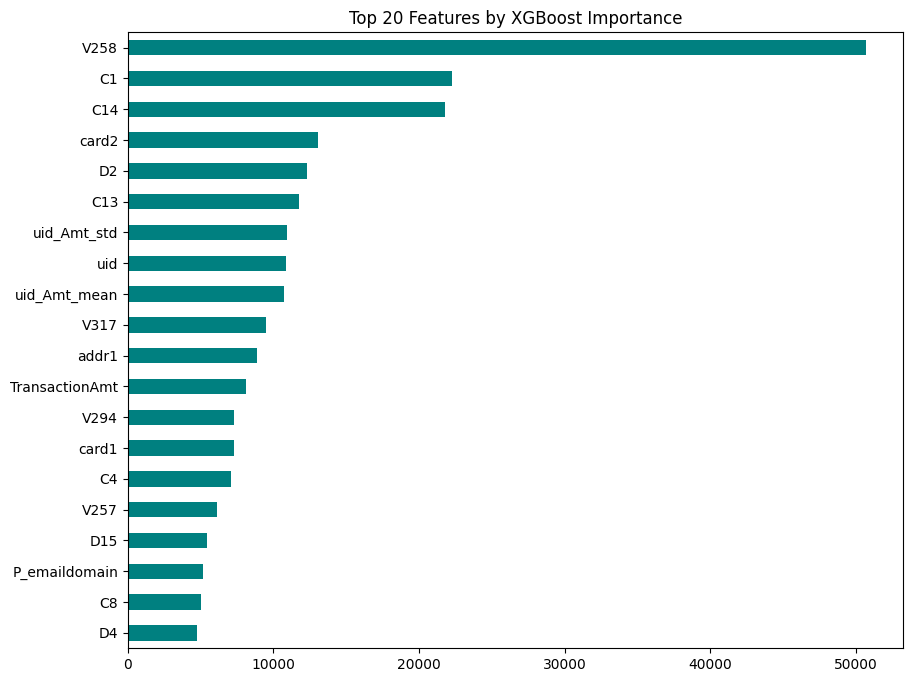

In [79]:
importances = pd.Series(clf.get_booster().get_score(importance_type='total_gain'))

# 2. Sort and Take Top 50
TOP_N = 100
best_features = importances.sort_values(ascending=False).head(TOP_N).index.tolist()

print(f"--- Top {TOP_N} Features Selected ---")
print(best_features[:10])  # Print top 10 to check

# 3. Visualize
plt.figure(figsize=(10, 8))
importances.sort_values(ascending=False).head(20).plot(kind='barh', color='teal')
plt.title('Top 20 Features by XGBoost Importance')
plt.gca().invert_yaxis() # Highest importance on top
plt.show()

In [ ]:
FINAL_CAT_COLS = []
FINAL_NUM_COLS = []

print("classifying Top Features...")

for col in best_features:
    # A. Is it an Object (String) in the original cleaned data?
    if X_train_clean[col].dtype == 'object':
        FINAL_CAT_COLS.append(col)
        
    # B. Is it a Number but behaves like a Category? (Few unique values)
    # Example: 'card4' might be 1, 2, 3, 4. Treat as Category.
    elif X_train_clean[col].nunique() < 20:
        FINAL_CAT_COLS.append(col)
        
    # C. Otherwise, it is a Number (Amount, Time, Distance)
    else:
        FINAL_NUM_COLS.append(col)

print(f"--------------------------------")
print(f"Feature Split for Neural Network:")
print(f" - Categorical (Embeddings): {len(FINAL_CAT_COLS)}")
print(f" - Numerical (Scaled):       {len(FINAL_NUM_COLS)}")
print(f"--------------------------------")

# After you get best_features from XGBoost importance:
manual_features = ['Amt_to_mean_ratio', 'hour', 'day_of_week']

for feat in manual_features:
    if feat not in best_features:
        best_features.append(feat)

# Now run your loop that splits into FINAL_CAT_COLS and FINAL_NUM_COLS
# ... (your existing loop) ...

# Verify they are in the list:
print(f"Is uid_count in numerical list? {'uid_count' in FINAL_NUM_COLS}")

# Finalize the Datasets
# We now discard all other columns and keep only the winners
X_train_ready = X_train_clean[best_features].copy()
X_val_ready   = X_val_clean[best_features].copy()
X_test_ready  = X_test_clean[best_features].copy()

classifying Top Features...
--------------------------------
Feature Split for Neural Network:
 - Categorical (Embeddings): 29
 - Numerical (Scaled):       71
--------------------------------
Is uid_count in numerical list? False


KeyError: "['uid_count', 'card1_count'] not in index"

In [ ]:
# 1. COMBINE TEMPORARILY
# We need to make sure "Visa" gets the same ID (e.g., 5) in both Train and Test.
all_data = pd.concat([X_train_ready, X_val_ready, X_test_ready])

print(f"Processing {all_data.shape[1]} features for {len(all_data)} rows...")

# 2. PROCESS CATEGORICAL COLUMNS (For Embeddings)
print("Encoding Categorical Features...")
for col in FINAL_CAT_COLS:
    # A. Force to String and Fill Missing
    all_data[col] = all_data[col].astype(str).fillna("Missing")
    
    # B. Label Encode (String -> Integer)
    le = LabelEncoder()
    all_data[col] = le.fit_transform(all_data[col])
    
    # C. Optimize Memory
    all_data[col] = all_data[col].astype('int32')

# 3. PROCESS NUMERICAL COLUMNS (For Scaling)
print("Scaling Numerical Features...")

# A. Fill Missing with MEAN (Average) instead of 0
# This prevents the model from thinking missing data equals "0.0 distance" or "0.0 money"
for col in FINAL_NUM_COLS:
    if col in all_data.columns:
        # Calculate average (ignoring NaNs)
        mean_val = all_data[col].mean()
            
        # Fill missing values
        all_data[col] = all_data[col].fillna(mean_val)

# B. Scale (Standardize to mean 0, std 1)
# Because we filled with mean, the missing values will technically become 0.0 
# AFTER this scaling step, which is the perfect "neutral" signal for a Neural Net.
scaler = StandardScaler()
all_data[FINAL_NUM_COLS] = scaler.fit_transform(all_data[FINAL_NUM_COLS])
all_data[FINAL_NUM_COLS] = all_data[FINAL_NUM_COLS].astype('float32')
# --- CHANGED SECTION END ---

# 4. SPLIT BACK APART
# We use the lengths of your original sets to cut the big dataframe
len_train = len(X_train_ready)
len_val   = len(X_val_ready)

train_df_final = all_data.iloc[:len_train]
val_df_final   = all_data.iloc[len_train : len_train + len_val]
test_df_final  = all_data.iloc[len_train + len_val :]

# 5. CREATE DICTIONARIES (The TensorFlow Input Format)
# The model expects: {'feature_name': [values], ...}
def make_inputs(df):
    return {col: df[col].values for col in df.columns}

train_inputs = make_inputs(train_df_final)
val_inputs   = make_inputs(val_df_final)
test_inputs  = make_inputs(test_df_final)

print("✅ Data is fully prepped and ready for the Model!")

Processing 100 features for 590540 rows...
Encoding Categorical Features...
Scaling Numerical Features...
✅ Data is fully prepped and ready for the Model!


In [ ]:
from sklearn.utils import class_weight

# Calculate how much weight to give to Fraud (1) vs Safe (0)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary {0: 0.5, 1: 14.0}
# This tells the model: "Every Fraud mistake is 14x worse than a Safe mistake."
class_weights = {0: weights[0], 1: weights[1]}

print(f"Class Weights: {class_weights}")

Class Weights: {0: np.float64(0.5182253535252231), 1: np.float64(14.217155041959003)}


In [ ]:
def build_model(input_df, cat_cols, num_cols):
    inputs = {}
    encoded_features = []
    
    # --- A. CATEGORICAL INPUTS (Embeddings) ---
    for col in cat_cols:
        # 1. Input Layer (Receives the Integer ID)
        input_layer = layers.Input(shape=(1,), name=col)
        inputs[col] = input_layer
        
        # 2. Define Dictionary Size (Max ID + Buffer)
        vocab_size = int(input_df[col].max()) + 5
        
        # 3. Define Vector Size (Rule of thumb: half of vocab, max 50)
        embed_dim = min(50, (vocab_size + 1) // 2)
        
        # 4. Create Embedding (The Lookup Table)
        emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(input_layer)
        emb = layers.Flatten()(emb)
        encoded_features.append(emb)
        
    # --- B. NUMERICAL INPUTS (Direct) ---
    for col in num_cols:
        # 1. Input Layer (Receives the Scaled Number)
        input_layer = layers.Input(shape=(1,), name=col)
        inputs[col] = input_layer
        
        # 2. Add straight to the pile
        encoded_features.append(input_layer)
        
    # --- C. THE BRAIN (Deep Layers) ---
    # 1. Merge all inputs into one long row
    all_features = layers.concatenate(encoded_features)
    
    # 2. First Thinking Layer (256 Neurons)
    x = layers.Dense(256, activation='relu')(all_features)
    x = layers.BatchNormalization()(x) # Stabilize math
    x = layers.Dropout(0.3)(x)         # Prevent memorization
    
    # 3. Second Thinking Layer (128 Neurons)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # 4. Third Thinking Layer (64 Neurons)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # 5. Output Layer (0.0 to 1.0 probability)
    output = layers.Dense(1, activation='sigmoid', name='fraud_prob')(x)
    
    model = models.Model(inputs=inputs, outputs=output)
    return model

# BUILD IT
# We pass train_df_final to calculate the vocab sizes
model = build_model(train_df_final, FINAL_CAT_COLS, FINAL_NUM_COLS)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ P_emaildomain       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ card6 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ R_emaildomain       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V62 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V189 (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V70 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M4 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ id_31 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ProductCD           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V91 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DeviceInfo          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M6 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M5 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V12 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ card4 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V82 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V53 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V83 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V67 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DeviceType          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V76 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V54 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 250,018 (976.63 KB)

 Trainable params: 249,122 (973.13 KB)

 Non-trainable params: 896 (3.50 KB)

In [81]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

In [82]:
# 1. COMPILE (The Settings)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=focal_loss(gamma=2.0, alpha=0.25), 
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# 2. DEFINE CALLBACKS (The "Managers")
callbacks_list = [
    # A. The Sniper: Saves the model ONLY when AUC hits a new record high
    callbacks.ModelCheckpoint(
        filepath='best_fraud_model.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    
    # B. The Safety Net: Stops if we stop improving, and RESTORES the best version
    callbacks.EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=5,               # Wait 5 epochs to be sure
        restore_best_weights=True, # CRITICAL: Reverts model to the best epoch
        verbose=1
    ),
    
    # C. The Teacher: Lowers learning rate if the model gets stuck
    callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        mode='max',
        factor=0.5,
        patience=2,
        min_lr=0.00001,
        verbose=1
    )
]

# 3. TRAIN
print("🚀 Starting Training to Maximize ROC-AUC...")
print("The model will automatically save the version with the highest Validation AUC.")

history = model.fit(
    train_inputs, y_train,
    validation_data=(val_inputs, y_val),
    epochs=50,                  # Give it plenty of time (it will stop early anyway)
    batch_size=2048,            # Large batch size helps stability
    class_weight=class_weights, # Use the weights we calculated earlier
    callbacks=callbacks_list,
    verbose=1
)

🚀 Starting Training to Maximize ROC-AUC...
The model will automatically save the version with the highest Validation AUC.
Epoch 1/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8808 - loss: 0.0101
Epoch 1: val_auc improved from -inf to 0.85910, saving model to best_fraud_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - auc: 0.8808 - loss: 0.0101 - val_auc: 0.8591 - val_loss: 0.0109 - learning_rate: 5.0000e-04
Epoch 2/50
199/202 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8887 - loss: 0.0098
Epoch 2: val_auc improved from 0.85910 to 0.86138, saving model to best_fraud_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - auc: 0.8887 - loss: 0.0098 - val_auc: 0.8614 - val_loss: 0.0108 - learning_rate: 5.0000e-04
Epoch 3/50
201/202 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8894 - loss: 0.0098
Epoch 3: val_auc did not improve from 0.86138
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - auc: 0.8894 - loss: 0.0098 - val_auc: 0.8586 - val_loss: 0.0110 - learning_rate: 5.0000e-04


In [84]:
from sklearn.metrics import roc_auc_score

print("------------------------------------------------")
print("Evaluating Best Model on TEST Set...")

# 1. Get predictions (Probabilities between 0 and 1)
test_preds = model.predict(test_inputs, batch_size=2048).flatten()

# 2. Calculate the Final ROC-AUC
final_auc = roc_auc_score(y_test, test_preds)

print(f"🏆 FINAL TEST ROC-AUC: {final_auc:.5f}")
print("------------------------------------------------")

------------------------------------------------
Evaluating Best Model on TEST Set...
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
🏆 FINAL TEST ROC-AUC: 0.85301
------------------------------------------------
